In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


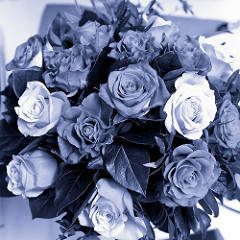

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [ ]:
# load image using tf.keras.preprocessing
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


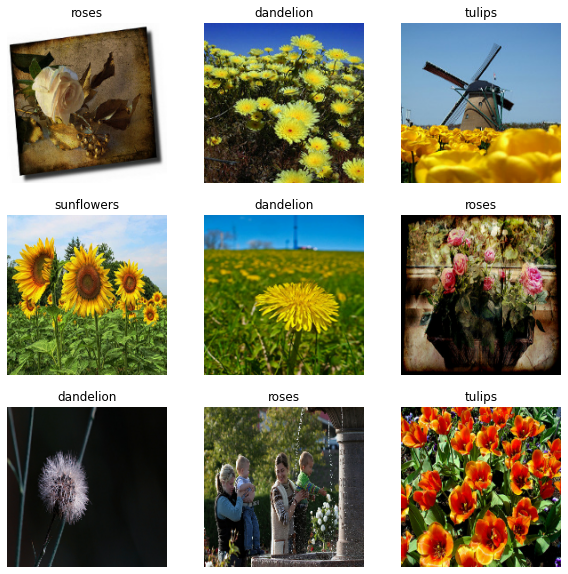

In [ ]:
# visualize data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1): 
  # ??
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
# data normalize
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.96902645


In [ ]:
# Organizing dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# cache() : maintain image in memory while first epoch - ?
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# prefetch(): ?

In [72]:
# train model
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer = 'adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)
# validation accuray is lower than train accuracy = overfitted

Epoch 1/3
92/92 [==============================] - 124s 1s/step - loss: 1.2540 - accuracy: 0.4687 - val_loss: 1.0893 - val_accuracy: 0.5654
Epoch 2/3
92/92 [==============================] - 113s 1s/step - loss: 1.0212 - accuracy: 0.5913 - val_loss: 1.0125 - val_accuracy: 0.5926
Epoch 3/3
92/92 [==============================] - 118s 1s/step - loss: 0.8853 - accuracy: 0.6505 - val_loss: 0.9222 - val_accuracy: 0.6458


In [73]:
# using tf.data for micro control
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [74]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/16449467833_d82aac5749_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/21984860006_20dfacea1c_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4980406384_791774d953.jpg'
b'/root/.keras/datasets/flower_photos/roses/4360743371_6238b36d8c_m.jpg'


In [75]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [76]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [77]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [78]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path,os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2]== class_names
  # ??
  # Integer encode the label
  return tf.argmax(one_hot)

In [79]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img,channels=3)
  # resize the image to the desired size
  return tf.image.resize(img,[img_height,img_width])

In [80]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [81]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [82]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [83]:
# Organizing dataset for performance

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

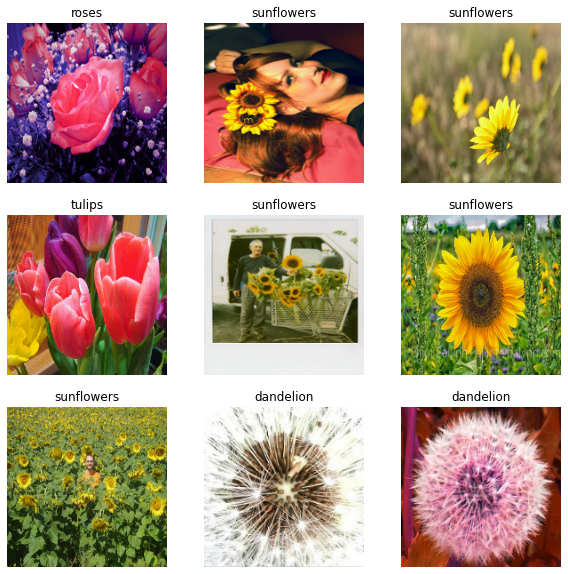

In [84]:
# visualize data
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [85]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 120s 1s/step - loss: 0.7826 - accuracy: 0.7030 - val_loss: 0.7511 - val_accuracy: 0.7302
Epoch 2/3
92/92 [==============================] - 114s 1s/step - loss: 0.6231 - accuracy: 0.7623 - val_loss: 0.7954 - val_accuracy: 0.7057
Epoch 3/3
92/92 [==============================] - 114s 1s/step - loss: 0.4750 - accuracy: 0.8260 - val_loss: 0.9189 - val_accuracy: 0.7071


In [86]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [87]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


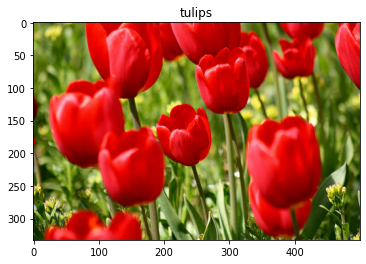

In [88]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [89]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)